# 프로젝트: 네이버 영화리뷰 감성분석

* 데이터셋 출처: 네이버영화리뷰(nsmc), https://github.com/e9t/nsmc
* 참고한 튜토리얼: https://wikidocs.net/44249
* label: 0(부정), 1(긍정)

In [75]:
# 시간 측정 
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1.18 s (started: 2021-01-21 09:53:59 +09:00)


In [76]:
# 사용 라이브러리
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import os, random
import tensorflow as tf

time: 4.12 ms (started: 2021-01-21 09:54:00 +09:00)


In [77]:
# random seed 
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
SEED = 225
set_seeds(SEED)

time: 31.7 ms (started: 2021-01-21 09:54:00 +09:00)


## 1. 데이터 준비와 확인

In [78]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

time: 263 ms (started: 2021-01-21 09:54:00 +09:00)


### 1.1. 데이터 개수 확인

In [79]:
print("train set: {}개".format(len(train_data)))
print("test set: {}개".format(len(test_data)))

train set: 150000개
test set: 50000개
time: 1.45 ms (started: 2021-01-21 09:54:01 +09:00)


### 1.2. 상위 5개 출력
* train과 test data를 각각 살펴보면서 columns에 해당하는 데이터의 속성(특징, feature)는 어떤 것이 있는지 확인한다. 
    - 여기서 주의할 점은 이미지 분류에서 생각해보면 valid set은 전처리를 해주면 안된다라는 개념과 결측치 처리는 다르다. 이때 말하는 전처리는 데이터 증강(augmentation)이나, 밝기 변화와 같은 직접적으로 데이터에 변화를 주는 것이다. 결측치 처리는 데이터 전처리라기 보단, 데이터 정제에 해당한다. 그래서 train, test 둘다 적용해주는 것이다. => 더 알아보자

In [80]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


time: 16.7 ms (started: 2021-01-21 09:54:01 +09:00)


In [81]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


time: 13.3 ms (started: 2021-01-21 09:54:01 +09:00)


### 1.3. Label 분포  확인

<AxesSubplot:>

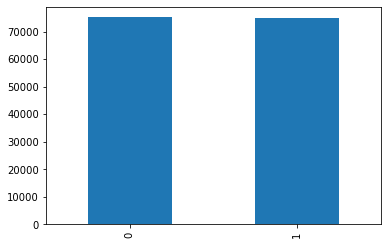

time: 109 ms (started: 2021-01-21 09:54:02 +09:00)


In [82]:
train_data['label'].value_counts().plot(kind = 'bar')

## 2. 데이터 로더 구성 
*  imdb.data_loader를 참고하면 숫자 인덱스로 변환된 텍스트와 딕셔너리를 제공한다. 가공되지 않은 nsmc 데이터셋을 데이터 전처리 해준다. 

In [83]:
X_train = []
X_test = []
y_train = []
y_test = []

time: 1.53 ms (started: 2021-01-21 09:54:02 +09:00)


### 2.1. 데이터의 중복 제거 
* data의 내용에서 중복이 되면 지워도 되는 데이터는 document열을 기준으로 할 수 있다. label은 0, 1로 분류를 하는 것이고, id는 고유할 것으로 예상되기 때문이다. 
* pandas의 unique(), value_counts() 함수는 유일한 값을 찾거나, 유일한 값별로 개수를 세준다. 
* 참고 블로그:https://rfriend.tistory.com/267

#### 중복값 확인 

In [84]:
# train 중복 개수 
len(train_data)-len(train_data['document'].value_counts())

3818

time: 118 ms (started: 2021-01-21 09:54:03 +09:00)


In [85]:
print(train_data['document'].value_counts())

굿                                                                                          181
good                                                                                        92
최고                                                                                          85
쓰레기                                                                                         79
별로                                                                                          66
                                                                                          ... 
제임스완 감독 팔아먹지마라.어디가 제임스완 감독이냐?                                                                1
조승우♥♥♥♥ 그냥 말이 필요없다                                                                           1
기억나는건 닭털뿐 ㅋㅋㅋㅋㅋㅋㅋ 쓰레기 공포영화보단 웃겨줘서 괜찮네.                                                       1
예전에 tv에서 봤던것 같은데.....분위기가 참 좋음......흔한 내용의 영화는 아니니 재미를 떠나서 영화를 좋아한다면 한번 봐도 후회하진 않을듯....      1
액션은 첩혈쌍웅보다 화려해 졌지만 감동은 확실히 떨어진다                   

In [86]:
# test 중복 개수 
len(test_data)-len(test_data['document'].value_counts())

843

time: 41.4 ms (started: 2021-01-21 09:54:04 +09:00)


In [87]:
print(test_data['document'].value_counts())

굿                                                                                                                                            56
good                                                                                                                                         35
최고                                                                                                                                           30
별로                                                                                                                                           20
tv 전기세가 아깝다!!!                                                                                                                               20
                                                                                                                                             ..
"마지막 대위가 일왕앞에가서 한 대사가 자꾸 생각나네. ""이 칼로 나라를 지켰던 사람들 ...""머시기 하는데, 그칼로 나라를 지켰다고? 남에나라 침략하는데 썼겠지 . 쨌든모티브가 된 줄거리가 정한론을 주장한 놈이 일으킨 반란이라 평점 낮게줌

#### 중복 제거
* 중복을 제거하기 위해서는 내장함수를 활용하거나 pandas를 활용할 수 있다. 
    - 내장함수에는 set(순서 중요하지 않을때)을 사용하거나 for문으로 요소를 확인 후 append하는 방식을 적용할 수 있다. 
    - 참고한 자료에서는 drop_duplicates이라는 함수를 사용했다. 
* 참고 출처: https://nittaku.tistory.com/124

In [88]:
#document열을 기준으로 중복행 제거
train_data.drop_duplicates(['document'],inplace = True) #inplace = False: None 반환, True: df에 적용 

time: 47.8 ms (started: 2021-01-21 09:54:05 +09:00)


In [89]:
#document열을 기준으로 중복행 제거
test_data.drop_duplicates(['document'], inplace = True) 

time: 27.5 ms (started: 2021-01-21 09:54:05 +09:00)


In [90]:
print(len(train_data)) # 중복 개수만큼 줄어든 Train dataset: 15000 -> 146183
print(len(test_data)) # 50000 -> 49158

146183
49158
time: 1.47 ms (started: 2021-01-21 09:54:06 +09:00)


### 2.x. 특수문자 제외 (추가 시도)

In [91]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


time: 218 ms (started: 2021-01-21 09:54:07 +09:00)


### 2.2. NaN 결측치 제거

#### NaN(Null값) 확인 
* 확인 결과, 결측치는 없었음 
* 데이터 양이 많을 때는 비율로 보기도 하나, Null이 적게 분포할때는 0%로 분석하게 될 수 있다. 영향은 미미하지만 결측치 여부를 종합하기 위해선 sum()으로 판단하는 것이 좋다고 판단했다. 

In [92]:
# null 비율 
for col in train_data.columns:
    print('column: {:>10}\t Percent of NULL: {:.2f}%'.format(col, 
          100 * (train_data[col].isnull().sum() / train_data[col].shape[0])))

column:         id	 Percent of NULL: 0.00%
column:   document	 Percent of NULL: 0.00%
column:      label	 Percent of NULL: 0.00%
time: 17.5 ms (started: 2021-01-21 09:54:08 +09:00)


In [93]:
# null 개수
for col in train_data.columns:
    print('column: {:>10}\t NULL value 개수: {}개'.format(col, 
          train_data[col].isnull().sum()))

column:         id	 NULL value 개수: 0개
column:   document	 NULL value 개수: 1개
column:      label	 NULL value 개수: 0개
time: 14.9 ms (started: 2021-01-21 09:54:08 +09:00)


In [94]:
# null 개수
for col in test_data.columns:
    print('column: {:>10}\t NULL value 개수: {}개'.format(col, 
          test_data[col].isnull().sum()))

column:         id	 NULL value 개수: 0개
column:   document	 NULL value 개수: 1개
column:      label	 NULL value 개수: 0개
time: 13.6 ms (started: 2021-01-21 09:54:08 +09:00)


#### 결측치 제거
* 제거 말고 평균이나 0으로 넣어주는 경우가 있으나 해당 경우는 1개로 매우 적으므로 제거한다. 

In [95]:
train_data.dropna(inplace = True)

time: 27.9 ms (started: 2021-01-21 09:54:09 +09:00)


In [96]:
# null 개수
for col in train_data.columns:
    print('column: {:>10}\t NULL value 개수: {}개'.format(col, 
          train_data[col].isnull().sum()))

column:         id	 NULL value 개수: 0개
column:   document	 NULL value 개수: 0개
column:      label	 NULL value 개수: 0개
time: 19.5 ms (started: 2021-01-21 09:54:09 +09:00)


In [97]:
test_data.dropna(inplace = True)

time: 18 ms (started: 2021-01-21 09:54:09 +09:00)


In [98]:
# null 개수
for col in train_data.columns:
    print('column: {:>10}\t NULL value 개수: {}개'.format(col, 
          train_data[col].isnull().sum()))

column:         id	 NULL value 개수: 0개
column:   document	 NULL value 개수: 0개
column:      label	 NULL value 개수: 0개
time: 11 ms (started: 2021-01-21 09:54:09 +09:00)


### 2.3. 한국어 토크나이저로 토큰화
* 왜 토큰화가 필요한가? 한국어는 영어와 다르게 띄어쓰기만으로 각 형태소가 구분되지 않는다. 단어에는 조사도 있고 동사도 있어서 Mecab은 형태소 분석기고 stopwords는 영어에서 띄어쓰기가 단어를 구분하듯이 한국어 전용 형태소 분석기이다.
* 참고 교재에서는 Okt라는 토크나이저를 쓰는데 stem 같은 정규화 기능이 있어서 과거형이나 수동/피동형들을 원래의? 날것?의 단어로 바꿔준다. e.g. 만들었다 > 만들다

In [99]:
from konlpy.tag import Mecab

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

num_words  = 10000

time: 9.46 ms (started: 2021-01-21 09:54:10 +09:00)


* 아래 코드를 수행할 때 append하니까 오래걸리는 느낌이 들어서 예제 코드 실행해봄 

### 2.4. 불용어(Stopwords) 제거
* document열의 한 행 요소를 문장 단위로 임시 리스트에 저장한 후 train에 append한다.

In [100]:
# 10초 정도 소요
for sentence in train_data['document']:
    X_tmp = []
    X_tmp = tokenizer.morphs(sentence) # 토큰화 
    X_tmp = [word for word in X_tmp if not word in stopwords] #불용어 제거 
    X_train.append(X_tmp)

time: 10.8 s (started: 2021-01-21 09:54:11 +09:00)


In [101]:
X_train[:3]

[['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '지', '않', '구나'],
 ['너무', '재', '밓었다그래서보는것을추천한다']]

time: 1.61 ms (started: 2021-01-21 09:54:22 +09:00)


In [102]:
# 4초 정도 소요
for sentence in test_data['document']:
    X_tmp = []
    X_tmp = tokenizer.morphs(sentence) # 토큰화 
    X_tmp = [word for word in X_tmp if not word in stopwords] #불용어 제거 
    X_test.append(X_tmp)

time: 3.59 s (started: 2021-01-21 09:54:22 +09:00)


In [103]:
X_test[:3]

[['굳', 'ㅋ'],
 ['GDNTOPCLASSINTHECLUB'],
 ['뭐',
  '야',
  '평점',
  '.',
  '...',
  '나쁘',
  '진',
  '않',
  '지만',
  '10',
  '점',
  '짜리',
  '더더욱',
  '아니',
  '잖아']]

time: 1.48 ms (started: 2021-01-21 09:54:26 +09:00)


### 2.5. 사전word_to_index 구성
* Counter를 사용해도 되고, Tokenizer로 fit_on_texts를 사용해도 정수 인코딩을 할 수 있다.

In [104]:
words = np.concatenate(X_train).tolist()
counter = Counter(words)
counter = counter.most_common(10000-4)
vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]

word_to_index = {word:index for index, word in enumerate(vocab)}

time: 894 ms (started: 2021-01-21 09:54:26 +09:00)


### 2.6. 텍스트 스트링을 사전 인덱스 스트링으로 변환

In [105]:
def wordlist_to_indexlist(wordlist):
    return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

time: 415 µs (started: 2021-01-21 09:54:27 +09:00)


In [106]:
X_train[0]

['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리']

time: 1.41 ms (started: 2021-01-21 09:54:27 +09:00)


### 2.7. X_train, y_train, X_test, y_test

In [107]:
X_train = list(map(wordlist_to_indexlist, X_train))
X_test = list(map(wordlist_to_indexlist, X_test))

time: 947 ms (started: 2021-01-21 09:54:27 +09:00)


In [108]:
X_train[:3]

[[27, 67, 895, 33, 214, 15, 28, 699],
 [977, 481, 491, 636, 4, 110, 1554, 48, 866, 949, 11, 38, 364],
 [19, 192, 2]]

time: 1.59 ms (started: 2021-01-21 09:54:28 +09:00)


In [109]:
y_train = np.array(list(train_data['label']))
y_test = np.array(list(test_data['label']))

time: 22.8 ms (started: 2021-01-21 09:54:28 +09:00)


#### index to word

In [110]:
index_to_word = {index:word for word, index in word_to_index.items()}

time: 3.05 ms (started: 2021-01-21 09:54:28 +09:00)


In [111]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

time: 1.23 ms (started: 2021-01-21 09:54:28 +09:00)


## 3. 모델 구성을 위한 데이터 분석 및 가공

### 데이터셋 내 문장 길이 분포 

In [112]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[27, 67, 895, 33, 214, 15, 28, 699]
라벨:  0
1번째 리뷰 문장 길이:  8
2번째 리뷰 문장 길이:  13
time: 733 µs (started: 2021-01-21 09:54:28 +09:00)


In [113]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  14.281080582986501
문장길이 최대 :  105
문장길이 표준편차 :  11.87192323676208
time: 45 ms (started: 2021-01-21 09:54:28 +09:00)


### 적절한 문장 최대 길이 지정 
* 분포를 통해 확인했을 때 문장의 최대 길이는 40정도가 적당해 보인다. 

리뷰의 최대 길이 : 105
리뷰의 평균 길이 : 14.281080582986501


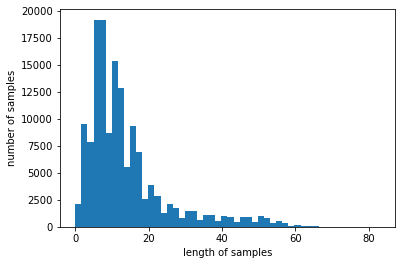

time: 582 ms (started: 2021-01-21 09:54:28 +09:00)


In [114]:
print('리뷰의 최대 길이 :', np.max(num_tokens))
print('리뷰의 평균 길이 :', np.mean(num_tokens))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

* 분포와 비슷한 계산수치를 사용해도 41 정도가 최대 길이로 보이고, 90%이상을 포함하므로 최대 길이를 41로 선정한다. 

In [115]:
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_len = int(max_tokens)
print('pad_sequences maxlen : ', max_len)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  38
전체 문장의 0.9366588341293853%가 maxlen 설정값 이내에 포함됩니다. 
time: 1.8 ms (started: 2021-01-21 09:54:28 +09:00)


### keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [116]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, 
                        maxlen = max_len,
                        value=word_to_index["<PAD>"],
                        padding='pre')
X_test = pad_sequences(X_test, 
                       maxlen = max_len,
                       value=word_to_index["<PAD>"],
                       padding='pre')

time: 717 ms (started: 2021-01-21 09:54:29 +09:00)


In [117]:
print(X_train.shape)
print(X_test.shape)

(146182, 38)
(49157, 38)
time: 1.46 ms (started: 2021-01-21 09:54:35 +09:00)


### 4.1. 모델 구성 

In [43]:
total_cnt = len(word_to_index)
vocab_size = total_cnt    # 어휘 사전의 크기입니다(10,000개의 단어)


time: 300 µs (started: 2021-01-21 08:21:38 +09:00)


In [44]:
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)
                                             #  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

time: 236 µs (started: 2021-01-21 08:21:38 +09:00)


* LSTM 모델 구성
    - 기존에 차원 8에서 64로 높임

In [45]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(64))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 64로 하였습니다. (변경가능)
# model.add(keras.layers.Dense(8, activation='relu')) # 안해도 됨
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                20736     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 180,801
Trainable params: 180,801
Non-trainable params: 0
_________________________________________________________________
time: 605 ms (started: 2021-01-21 08:21:38 +09:00)


* GlobalMaxPooling1D() 레이어 하나만 사용

In [46]:
# model = keras.Sequential()
# model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
# model.add(keras.layers.GlobalMaxPooling1D())
# model.add(keras.layers.Dense(8, activation='relu'))
# model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

# model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________
time: 26.5 ms (started: 2021-01-21 08:21:39 +09:00)


### 4.2. 데이터셋 분리
* 테스트가 약 15000여개가 있으므로 4:1 비율로 Valid를 할당한다. 
* 따라서 valid set은 전체 train set에서 약 20%에 해당하는 29300만건 정도 할당한다

In [47]:
print(X_train.shape[0]*0.2)

29236.4
time: 415 µs (started: 2021-01-21 08:21:39 +09:00)


In [48]:
# validation set 29300건 분리
X_val = X_train[:29300]   
y_val = y_train[:29300]

# validation set을 제외한 나머지 
partial_X_train = X_train[29300:]  
partial_y_train = y_train[29300:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(116882, 38)
(116882,)
time: 584 µs (started: 2021-01-21 08:21:39 +09:00)


## 5. 모델 훈련 개시 
* 최고 점수 나오는 모델을 저장할 수 있도록 함 (추가 시도)

In [50]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

time: 713 µs (started: 2021-01-21 08:22:10 +09:00)


* batch size는 얼마만큼 묶음지어서 학습시킬 것이냐이기 때문에 512는 너무 커서 100정도로 줄여서 시도했다. 값은 일반적으로 60, 80정도 잡길래 일단 100으로 줄였다.(추가 시도)

In [51]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512, # 512, 100 
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks = [es, mc])

Epoch 1/20
1169/1169 [==============================] - 3s 2ms/step - loss: 0.4614 - accuracy: 0.7971 - val_loss: 0.3666 - val_accuracy: 0.8340
Epoch 2/20
1169/1169 [==============================] - 3s 2ms/step - loss: 0.3383 - accuracy: 0.8536 - val_loss: 0.3579 - val_accuracy: 0.8397
Epoch 3/20
1169/1169 [==============================] - 3s 2ms/step - loss: 0.3021 - accuracy: 0.8728 - val_loss: 0.3608 - val_accuracy: 0.8404
Epoch 4/20
1169/1169 [==============================] - 3s 2ms/step - loss: 0.2771 - accuracy: 0.8846 - val_loss: 0.3682 - val_accuracy: 0.8417
Epoch 5/20
1169/1169 [==============================] - 3s 3ms/step - loss: 0.2572 - accuracy: 0.8949 - val_loss: 0.3813 - val_accuracy: 0.8408
Epoch 6/20
1169/1169 [==============================] - 3s 3ms/step - loss: 0.2417 - accuracy: 0.9029 - val_loss: 0.3927 - val_accuracy: 0.8401
Epoch 7/20
1169/1169 [==============================] - 3s 3ms/step - loss: 0.2275 - accuracy: 0.9092 - val_loss: 0.4095 - val_accuracy:

## 6. Loss, Accuracy 그래프 시각화

In [52]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4235 - accuracy: 0.8277
[0.423517107963562, 0.8277356028556824]
time: 1.83 s (started: 2021-01-21 08:22:40 +09:00)


In [53]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
time: 679 µs (started: 2021-01-21 08:22:41 +09:00)


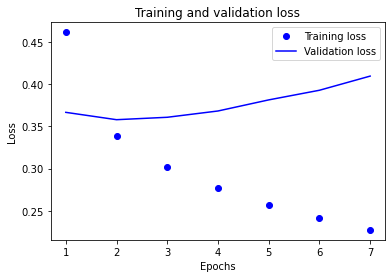

time: 131 ms (started: 2021-01-21 08:22:41 +09:00)


In [54]:

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

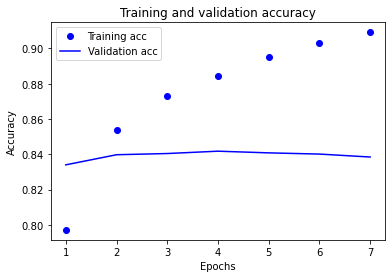

time: 116 ms (started: 2021-01-21 08:22:42 +09:00)


In [55]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 7. 학습된 Embedding 레이어 분석

In [56]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)
time: 2.59 ms (started: 2021-01-21 08:22:42 +09:00)


In [57]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

time: 115 ms (started: 2021-01-21 08:22:42 +09:00)


## 8. 한국어 Word2Vec 임베딩 활용하여 성능개선

In [ ]:
from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']

In [ ]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

In [ ]:
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

### 8.1. CNN에 임베딩벡터를 적용 

In [ ]:
# from tensorflow.keras.initializers import Constant

# # 모델 구성
# model = keras.Sequential()
# model.add(keras.layers.Embedding(vocab_size, 
#                                  word_vector_dim, 
#                                  embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
#                                  input_length=max_len, 
#                                  trainable=True))   # trainable을 True로 주면 Fine-tuning
# model.add(keras.layers.Conv1D(16, 5, activation='relu')) #16, 32 (추가시도)
# model.add(keras.layers.MaxPooling1D(5))
# model.add(keras.layers.Conv1D(16, 5, activation='relu')) #negative error가 떠서 커널 사이즈를 줄여줬다. (추가 시도)
# model.add(keras.layers.GlobalMaxPooling1D())
# model.add(keras.layers.Dense(16, activation='relu'))
# model.add(keras.layers.Dense(1, activation='sigmoid')) 

# model.summary()

### 8.2. LSTM에 임베딩 벡터 적용 

In [ ]:
from tensorflow.keras.initializers import Constant

model = keras.Sequential()
model.add(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=max_len, 
                                 trainable=True))
model.add(keras.layers.LSTM(64))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 64로 하였습니다. (변경가능)
# model.add(keras.layers.Dense(8, activation='relu')) # 안해도 됨
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

In [ ]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 15

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=100,
                    validation_data=(X_val, y_val),
                    verbose=1)

In [ ]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

## 10. 루브릭 및 회고

### 10.1. 루브릭
* 3가지 이상의 모델이 성공적으로 시도됨
* gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함
* 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함

### 10.2. 회고